In [193]:
# data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
# data-lab-3-insurance
# data-lab-4-heart
# data-lab-5-hcv
# data-lab-6-ckd-courseproject
# data.info()

In [194]:
import pandas as pd 
import numpy as np 
import seaborn as sns
sns.set(style='dark', palette='muted', color_codes=True)
import plotly.express as px
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

In [195]:
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler 
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, confusion_matrix, accuracy_score 
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier 
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer

In [196]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-5-hcv.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


In [197]:
mis_col = data.isna().sum() * 100/len(data)

mis_col.sort_values(ascending=False)

ALP           2.926829
CHOL          1.626016
ALB           0.162602
ALT           0.162602
PROT          0.162602
Unnamed: 0    0.000000
Category      0.000000
Age           0.000000
Sex           0.000000
AST           0.000000
BIL           0.000000
CHE           0.000000
CREA          0.000000
GGT           0.000000
dtype: float64

In [198]:
# [['ALP', 'CHOL', 'ALB', 'ALT', 'PROT']] 

In [199]:

mean_imp = SimpleImputer(strategy='mean', missing_values=np.NAN)

data[['ALP', 'CHOL', 'ALB', 'ALT', 'PROT']] = mean_imp.fit_transform(data[['ALP', 'CHOL', 'ALB', 'ALT', 'PROT']])
mis_col = data.isna().sum() * 100/len(data)

mis_col.sort_values(ascending=False)

Unnamed: 0    0.0
Category      0.0
Age           0.0
Sex           0.0
ALB           0.0
ALP           0.0
ALT           0.0
AST           0.0
BIL           0.0
CHE           0.0
CHOL          0.0
CREA          0.0
GGT           0.0
PROT          0.0
dtype: float64

In [200]:
data.duplicated().sum()

data.drop_duplicates(keep='first', subset=None, inplace=True, ignore_index=False)
data.duplicated().sum()

0

In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         615 non-null    float64
 5   ALP         615 non-null    float64
 6   ALT         615 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        615 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        615 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 72.1+ KB


In [202]:
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
# data

In [203]:
le =LabelEncoder()

In [204]:
y = data.Category 

y_true = le.fit_transform(y)

data = pd.get_dummies(data, dtype=float)
# data

In [205]:
le.classes_ 

n_clusters = len(le.classes_)

In [206]:
preprocessor = Pipeline( 
    [ 
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=2, random_state=42))
    ]
    
)

In [207]:

clusterer = Pipeline( 
    [ 
        ( 
            'kmeans',
            KMeans( 
                n_clusters=n_clusters,
                init='k-means++',
                n_init=50,
                max_iter=500,
                random_state=42
            )
        )
    ]
)

In [208]:
pipe = Pipeline( 
    [ 
        ('preprocessor', preprocessor),
        ('clusterer', clusterer)
    ]
)

In [209]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [210]:
preprocessed_data = pipe['preprocessor'].transform(data)
predicted_labels = pipe['clusterer']['kmeans'].labels_

sil_scr = silhouette_score(preprocessed_data, predicted_labels).round(3)

sil_scr

0.946

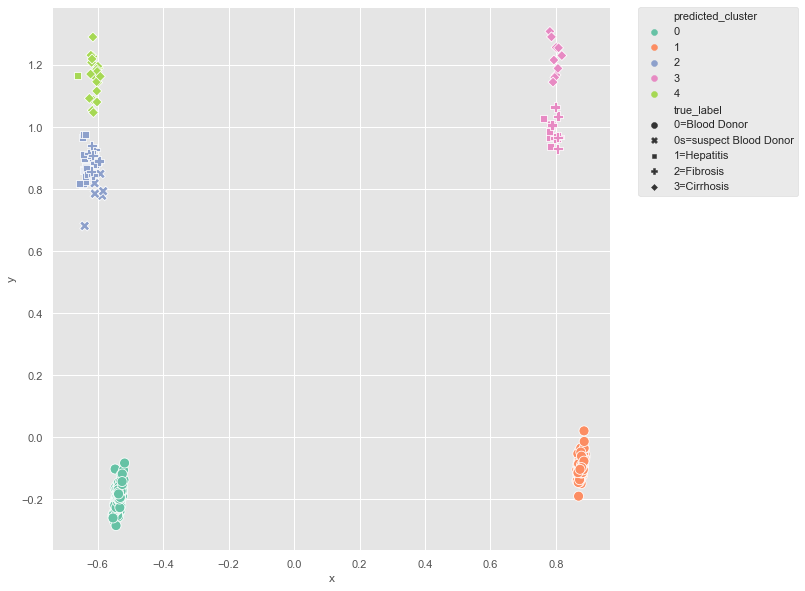

In [211]:
pcdaf = pd.DataFrame( 
    preprocessed_data,
    columns=['x', 'y']
)

pcdaf['predicted_cluster'] = predicted_labels

pcdaf['true_label'] = le.inverse_transform(y_true)

# f,ax = 
plt.figure(figsize=(10,10))

# ax.set_title('Predicted Cluster')

scat = sns.scatterplot( 
    data=pcdaf,
    s=100,
    x='x',
    y='y',
    hue='predicted_cluster',
    style='true_label',
    palette='Set2'

)

scat.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.0)

plt.show()